#Image Classifier using Local Descriptors

##Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import pickle

from imutils import paths
from collections import Counter

from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 

from skimage import feature
from skimage import exposure

from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix

from google.colab import drive

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/Image Classification/Caltech20/'

training_dir = root_path + 'training/'
test_dir = root_path + 'testing/'

# !unzip 'gdrive/My Drive/Colab Notebooks/Image Classification/Caltech20.zip' -d 'gdrive/My Drive/Colab Notebooks/Image Classification/'

Mounted at /content/gdrive


##Functions and Parameters

In [3]:
classes = ['airplanes',
 'anchor',
 'background_class',
 'barrel',
 'camera',
 'car_side',
 'dalmatian',
 'Faces',
 'ferry',
 'headphone',
 'lamp',
 'pizza',
 'pyramid',
 'snoopy',
 'soccer_ball',
 'stop_sign',
 'strawberry',
 'sunflower',
 'water_lilly',
 'windsor_chair',
 'yin_yang']

In [4]:
def dataset_prep(dir_path, classes):
  
  labels = []
  flag = 0

  for imagePath in paths.list_images(dir_path):
    
    image_class = imagePath.split("/")[-2]

    img = Image.open(imagePath).convert('L') # To open image as gray scale
    image_array = np.asarray(img) 

    H = hog_calculator(image_array)

    i = classes.index(image_class) + 1
    labels.append(i)

    if flag == 0:
      flag = 1
      descriptors = H.copy()
    else:
      descriptors = np.concatenate((descriptors, H), axis=0) 

  return labels, descriptors

###HOG Descriptor

In [5]:
def hog_calculator(image_array, block_size = (2, 2), cell_size = (8, 8), s=(64, 128)):

  local_descriptors = []

  n = int(s[0]/cell_size[0]) # number of cells in a row
  m = int(s[1]/cell_size[1]) # number of cells in a column

  # First step is to resize the image into 128x256 size
  resized_image = cv2.resize(image_array, s)
  im = Image.fromarray(resized_image)

  histogram_matrix = np.zeros((n, m, 18))

  for j in range(m):
    for i in range(n):

      # Boundaries of a cell
      cell_x_0 = i*cell_size[0]
      cell_x_1 = (i+1)*cell_size[0]
      cell_y_0 = j*cell_size[1]
      cell_y_1 = (j+1)*cell_size[1]

      cell = resized_image[cell_y_0:cell_y_1, cell_x_0:cell_x_1]
      magnitudes = np.zeros(cell.shape)
      orients = np.zeros(cell.shape)

      cell = cell.astype(np.int32)
      cell_row, cell_col = cell.shape

      cell = np.pad(cell, 1 , mode='constant')

      # Compute gradients and orientations
      for k in range(1, cell_row+1):
        for l in range(1, cell_col+1):

          y_grad = cell[k+1,l] - cell[k-1, l]
          x_grad = cell[k, l+1] - cell[k, l-1]
          magnitudes[k-1,l-1] = np.sqrt(x_grad**2 + y_grad**2)
          orients[k-1,l-1] = np.degrees(np.arctan2(y_grad, x_grad)) + 180

      bins = np.arange(0, 360, 20) 
      hist = np.zeros(bins.shape)

      # Turning gradients and orientations into histogram
      for row in range(cell_row):
        for col in range(cell_col):

          angle = orients[row,col]
          mag = magnitudes[row,col]

          position = np.argmax(bins > angle)

          hist[position-1] += ((bins[position] - angle)/20)*mag
          hist[position] += ((angle - bins[position-1])/20)*mag

      histogram_matrix[i, j] = hist

  for i in range(n+1-block_size[0]): # Number of blocks per row
    for j in range(m+1-block_size[1]): # Number of blocks per column
      block_array = np.concatenate((histogram_matrix[i, j],histogram_matrix[i+1, j], histogram_matrix[i, j+1], histogram_matrix[i+1, j+1]))
      norm = np.linalg.norm(block_array)
      if norm != 0:
        block_array = block_array/norm
      local_descriptors.append(block_array)

  return np.array(local_descriptors)

In [6]:
  # imagePath = training_dir + 'strawberry/image_0130.jpg'
  # img = Image.open(imagePath).convert('L')
  # image_array = np.asarray(img) 
  # print(image_array.shape)
  # local_descriptors = hog_calculator(image_array)

In [7]:
# local_descriptors.shape

In [8]:
# plt.imshow(img)
# plt.show()

###HOG Visualization

In [9]:
# H, hogImage = feature.hog(logo, orientations=9, 
#                 pixels_per_cell=(8, 8), 
#                 cells_per_block=(2, 2), 
#                 transform_sqrt=True, 
#                 block_norm="L1",
#                 visualize=True)

# hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
# hogImage = hogImage.astype("uint8")

In [10]:
# plt.imshow(hogImage)
# plt.show()

###Dictionary - Hierarchical Clustering & K-means

In [11]:
def hierarchical_clustering(descriptors, cluster_size):
  cluster = AgglomerativeClustering(n_clusters=cluster_size, affinity='euclidean', linkage='ward')
  cluster.fit_predict(descriptors)
  return cluster.labels_

In [12]:
def kmeans_clustering(descriptors, cluster_size, seed):
  kmeans = KMeans(n_clusters=cluster_size, max_iter=100,  random_state=seed)
  kmeans.fit(descriptors)
  return kmeans, kmeans.labels_

###Quantization

In [13]:
def bag_of_visual_words(clusters, cluster_size, descriptor_size):

  X = []
  n = clusters.shape[0]
  image_number = int(n/descriptor_size)

  for i in range(image_number):
    hist = np.zeros(cluster_size)
    clusters_i = clusters[i*descriptor_size:(i+1)*descriptor_size] 

    for j in range(cluster_size):
      hist[j]  = np.count_nonzero(clusters_i == j)
      
    hist = hist/descriptor_size
    X.append(hist)

  return X

###Parameters

In [14]:
seed = 1234
cluster_size = 50
image_resize = (64, 128)
descriptor_size = int((image_resize[0]/8-1)*(image_resize[1]/8-1))

##Dataset Prep

###Training Data

In [15]:
labels, descriptors = dataset_prep(training_dir, classes)

In [16]:
kmeans, clusters = kmeans_clustering(descriptors, cluster_size, seed)

In [54]:
X = bag_of_visual_words(clusters, cluster_size, descriptor_size)
y_train = labels

In [55]:
counter = Counter(labels)
print(counter)

Counter({1: 780, 15: 640, 5: 600, 19: 555, 17: 520, 6: 515, 14: 485, 7: 470, 9: 470, 3: 467, 18: 454, 16: 440, 11: 410, 8: 405, 13: 370, 20: 360, 4: 270, 10: 203, 21: 200, 2: 165, 12: 165})


In [42]:
under_str = {1:400, 3:400, 5: 400, 6:400, 7:400, 9:400, 14:400, 15:400, 17:400, 19:400}
# over_str = {2:500, 4:500, 10:500, 12:400}

In [47]:
# oversample = RandomOverSampler(sampling_strategy=over_str)
# X_over, y_over = oversample.fit_resample(X, labels)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [56]:
# undersample = NearMiss(version=1, n_neighbors=3)
# undersample = CondensedNearestNeighbour(n_neighbors=3)
# undersample = TomekLinks(sampling_strategy='majority')
undersample = RandomUnderSampler(sampling_strategy=under_str)

X_train, y_train = undersample.fit_resample(X, labels)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [58]:
counter_undersampled = Counter(y_train)
for i in range(1,22):
  print(i, classes[i-1], '\t',counter_undersampled[i])

1 airplanes 	 400
2 anchor 	 165
3 background_class 	 400
4 barrel 	 270
5 camera 	 400
6 car_side 	 400
7 dalmatian 	 400
8 Faces 	 405
9 ferry 	 400
10 headphone 	 203
11 lamp 	 410
12 pizza 	 165
13 pyramid 	 370
14 snoopy 	 400
15 soccer_ball 	 400
16 stop_sign 	 440
17 strawberry 	 400
18 sunflower 	 400
19 water_lilly 	 400
20 windsor_chair 	 360
21 yin_yang 	 200


In [59]:
s = set(counter_undersampled)
print(s)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}


###Test Data

In [26]:
y_test , X_test = dataset_prep(test_dir, classes)

In [27]:
test_clusters = kmeans.predict(X_test)

In [28]:
X_test = bag_of_visual_words(test_clusters, cluster_size, descriptor_size)

##Classifier - Random Forest

In [81]:
modelRF = RandomForestClassifier(criterion='gini', 
                                 oob_score=True, 
                                 random_state=seed, 
                                 bootstrap= True, 
                                 max_depth=50, 
                                 max_features='auto', 
                                 min_samples_leaf= 1, 
                                 min_samples_split=5, 
                                 n_estimators=800)
modelRF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=True, random_state=1234,
                       verbose=0, warm_start=False)

In [82]:
print(modelRF.score(X_test, y_test))
print(modelRF.oob_score_)

0.21842105263157896
0.24174336762317272


In [31]:
# parameters = {'criterion' : ['gini'],
#               'bootstrap': [True],
#               'max_depth': [10, 20, 40, 80, None],
#               'max_features': ['auto', 'sqrt'],
#               'min_samples_leaf': [1, 2, 4],
#               'min_samples_split': [2, 5, 10],
#               'n_estimators': [100, 200, 400]}

# RF = RandomForestClassifier(random_state=seed)

In [32]:
# gridsearch = GridSearchCV(RF, parameters, refit='AUC')
# gridsearch.fit(X_train, y_train)

In [78]:
# parameters = {'criterion' : ['gini'],
#               'bootstrap': [True],
#               'max_depth': [5, 10, 50, 100],
#               'n_estimators': [400, 600, 800]}

# RF = RandomForestClassifier(random_state=seed)

In [79]:
# gridsearch = GridSearchCV(RF, parameters, refit='f1_macro')
# gridsearch.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [80]:
# gridsearch.best_params_

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 50, 'n_estimators': 800}

###Performance Evaluation - RF

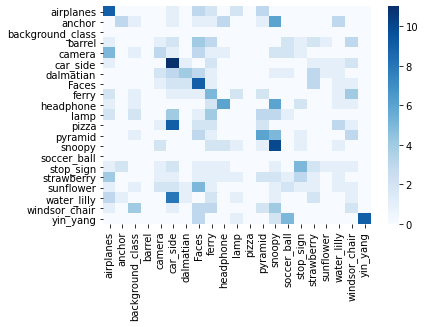

In [83]:
RF_predictions = modelRF.predict(X_test)
hmap = sns.heatmap(metrics.confusion_matrix(y_test, RF_predictions) , cmap='Blues', xticklabels=classes, yticklabels=classes)

In [84]:
print(classification_report(y_test, RF_predictions, target_names=classes))

                  precision    recall  f1-score   support

       airplanes       0.29      0.45      0.35        20
          anchor       0.50      0.15      0.23        20
background_class       0.00      0.00      0.00         0
          barrel       0.00      0.00      0.00        20
          camera       0.21      0.15      0.18        20
        car_side       0.22      0.55      0.32        20
       dalmatian       0.40      0.20      0.27        20
           Faces       0.21      0.45      0.29        20
           ferry       0.14      0.25      0.18        20
       headphone       0.43      0.30      0.35        20
            lamp       0.00      0.00      0.00        20
           pizza       0.00      0.00      0.00        20
         pyramid       0.27      0.30      0.29        20
          snoopy       0.23      0.50      0.31        20
     soccer_ball       0.00      0.00      0.00         0
       stop_sign       0.33      0.25      0.29        20
      strawbe

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##MLP

In [66]:
mlp = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [67]:
mlp.score(X_test, y_test)

0.22105263157894736

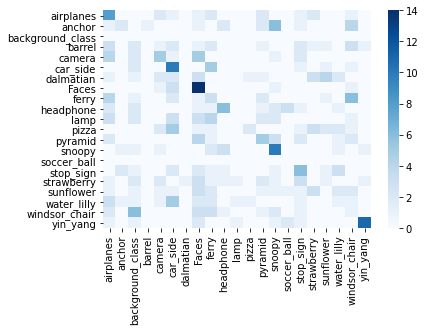

In [68]:
MLP_predictions = mlp.predict(X_test)
hmap = sns.heatmap(metrics.confusion_matrix(y_test, MLP_predictions) , cmap='Blues', xticklabels=classes, yticklabels=classes)

In [72]:
print(classification_report(y_test, MLP_predictions, target_names=classes))

                  precision    recall  f1-score   support

       airplanes       0.22      0.40      0.29        20
          anchor       0.33      0.10      0.15        20
background_class       0.00      0.00      0.00         0
          barrel       0.00      0.00      0.00        20
          camera       0.28      0.25      0.26        20
        car_side       0.27      0.50      0.35        20
       dalmatian       0.00      0.00      0.00        20
           Faces       0.28      0.70      0.40        20
           ferry       0.10      0.15      0.12        20
       headphone       0.43      0.30      0.35        20
            lamp       0.00      0.00      0.00        20
           pizza       0.50      0.10      0.17        20
         pyramid       0.25      0.25      0.25        20
          snoopy       0.32      0.50      0.39        20
     soccer_ball       0.00      0.00      0.00         0
       stop_sign       0.25      0.30      0.27        20
      strawbe

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
